# Artifact Booster Price Analysis

## Are Artifact Boosters Truly Random?

Artifact Boosters cost 2 USD ~ 139 INR and the price hasn't changed since launch, however all artifact cards are freely tradeable on the steam market place. If boosters are truly random this shouldn't be stable.

If the expected price of boosters is higher than the market rate for those cards from boosters, people will buy boosters and sell them on the market, this should drive down the card price to at least $P(card) \times 139$, where $P(card)$ is the probability of finding a card in a booster.

I believe this price can be even lower as new cards enter the market, either as part of initial artifact purchases or as excess from constructed or keeper draft. 

Valve could correct this by changing the distribution of cards in a booster (within the booster constraints) to closely match the market prices in order to have $E(booster) \sim 139$

Recently selling all my boosters on the market netted me ~144 per booster which is close enough to the fixed price of a booster to make me believe that Valve could be doing this. Here I'll be analysing whether how unlikely this is to happen given the ideal distribution of boosters and the price of cards on the market.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
sns.set()

## Data Sets

### All Artifact Cards

Prices have been taken from the Steam Market Place (2018/12/10), card rarity from [ArtifactFire](https://www.artifactfire.com/artifact/cards)

In [3]:
all_cards = pd.read_csv("data/all_cards.csv")
print(len(all_cards), "unique cards")
all_cards.head()

303 unique cards


,name,rarity,type,colour,cost,gold
0,Abaddon,Uncommon,Hero,green,NaN,NaN
1,Act of Defiance,Uncommon,Spell,green,5.0,NaN
2,Aghanim's Sanctum,Uncommon,Improvement,blue,4.0,NaN
3,Allseeing One's Favor,Rare,Spell,green,4.0,NaN
4,Altar of the Mad Moon,Uncommon,Improvement,green,4.0,NaN


### Market Listings (2018/12/10)

In [4]:
market = pd.read_csv("data/market.csv")
print(len(market), "market listings")
market.head()

237 market listings


,quantity,price,name
0,2413,2.11,Arcane Assault
1,2420,2.30,Arcane Censure
2,6138,2.23,Arm the Rebellion
3,5277,2.20,Avernus' Blessing
4,5437,2.14,Bellow


In [5]:
market_rarity = (market
                 .merge(all_cards, how="left", on="name") # Not every card has a market listing
                 [["name", "price", "rarity", "type"]])
print(len(market_rarity), "market listings with info")
market_rarity.head()

237 market listings with info


,name,price,rarity,type
0,Arcane Assault,2.11,Common,Spell
1,Arcane Censure,2.30,Common,Spell
2,Arm the Rebellion,2.23,Common,Spell
3,Avernus' Blessing,2.20,Common,Spell
4,Bellow,2.14,Common,Spell


### My Boosters

Unfortunately I didn't write down the cards I received from the boosters so have to reconstruct them from my market history.

In [6]:
my_sales = (pd.read_csv("data/my_cards.csv")
            .assign(count=1)
            .groupby("name")
            .agg({"price": "mean",
                  "count": "count"})
            .assign(count=lambda df: df["count"]/2))
print(len(my_sales), "unique cards") 
print(int(my_sales["count"].sum()), "cards sold")
my_sales.head()

97 unique cards
182 cards sold


,price,count
name,,
Annihilation,403.39,1.0
Arcane Censure,1.67,1.0
Arm the Rebellion,1.75,5.0
Assassin's Apprentice,1.66,2.0
Assassin's Veil,1.73,1.0


These prices are for 2018/12/09 which is a day before I took the market snapshot, while the individual prices could be different, what I care about is the price distribution within the boosters and the market.

Valve provides 2 starter sets with each purchase of Artifact which I'll need to remove to isolate the Booster cards

In [7]:
blue_black = pd.read_csv("data/blue_black.csv")
red_green = pd.read_csv("data/red_green.csv")
starter_sets = (blue_black
                .append(red_green))
starter_sets.head()

,name,quantity
0,Battlefield Control,3
1,Ventriloquy,2
2,Grazing Shot,2
3,Trebuchets,2
4,Lightning Strike,2


In [8]:
my_boosters = (my_sales
               .merge(starter_sets, on="name", how="outer")
               .fillna(0)
               .assign(additional=lambda df: df["count"] - df["quantity"])
               .loc[lambda df: df["additional"] > 0]
               [["name", "price", "additional"]]
               .rename(columns={"additional": "quantity"})
               .merge(all_cards[["name", "type", "rarity"]], on="name"))

print(int(my_boosters["quantity"].sum()), "booster cards")
my_boosters.head()

120 booster cards


,name,price,quantity,type,rarity
0,Annihilation,403.39,1.0,Spell,Rare
1,Arcane Censure,1.67,1.0,Spell,Common
2,Arm the Rebellion,1.75,3.0,Spell,Common
3,Assassin's Veil,1.73,1.0,Item,Uncommon
4,Avernus' Blessing,1.85,3.0,Spell,Common


In [9]:
my_price = sum(my_boosters["price"] * my_boosters["quantity"])
print("Total price of my 10 Boosters, {} INR".format(my_price))

Total price of my 10 Boosters, 1443.34 INR


## Booster Distribution

Each Booster pack contains 12 cards
* 1 Rare, 3 Uncommon, 8 Common Cards
* Common, then Uncommon cards have a 5% chance of upgrading
* 1 Card will be a Hero
* 2 Cards will be Items

### Card Key

For efficient random sampling i'm assigning a unique prime to every card attribute that I care about, here that's `rarity` and `type`

In [10]:
rarity_key = {"common": 1, "uncommon": 2, "rare": 3}
type_key = {"other": 5, "item": 7, "hero": 11}

acc = []
for (rv, rk) in rarity_key.items():
    for (tv, tk) in type_key.items():
        acc.append((rk, rv, tk, tv, rk*tk))

card_keys = (pd.DataFrame(acc, columns=["rarity_key", "rarity_value", "type_key", "type_value", "combo_key"])
             .set_index("combo_key"))
card_keys

,rarity_key,rarity_value,type_key,type_value
combo_key,,,,
5,1,common,5,other
7,1,common,7,item
11,1,common,11,hero
10,2,uncommon,5,other
14,2,uncommon,7,item
22,2,uncommon,11,hero
15,3,rare,5,other
21,3,rare,7,item
33,3,rare,11,hero


### Sampled Boosters

In [11]:
NUM_BOOSTERS = 10
NUM_SAMPLES = 10000

rarity_pack = 1 * [rarity_key["rare"]] +\
              3 * [rarity_key["uncommon"]] +\
              8 * [rarity_key["common"]]

rarity_samples = np.tile(rarity_pack, (NUM_SAMPLES, NUM_BOOSTERS, 1))

common_upgrade = (stats.binom.rvs(n=1, p=0.05, size=(NUM_SAMPLES, NUM_BOOSTERS, 8)) +\
                  stats.binom.rvs(n=1, p=0.05, size=(NUM_SAMPLES, NUM_BOOSTERS, 8)))
uncommon_upgrade = stats.binom.rvs(n=1, p=0.05, size=(NUM_SAMPLES, NUM_BOOSTERS, 3))
rare_upgrade = np.zeros((NUM_SAMPLES, NUM_BOOSTERS, 1))
upgrade = np.concatenate([rare_upgrade, uncommon_upgrade, common_upgrade], axis=2)

rarity = rarity_samples + upgrade.astype(int)

type_pack = 1 * [type_key["hero"]] +\
            2 * [type_key["item"]] +\
            9 * [type_key["other"]]

type_samples = np.tile(type_pack, (NUM_SAMPLES, NUM_BOOSTERS, 1))

for sample in type_samples:
    for pack in sample:
        np.random.shuffle(pack)

cards = type_samples * rarity
cards.shape

(10000, 10, 12)

In [12]:
acc = []
for sample in cards.reshape(NUM_SAMPLES, -1):
    acc.append(np.bincount(sample, minlength=34)[card_keys.index])
samples = np.vstack(acc)
samples.shape

(10000, 9)

### Card Distribution

In [13]:
booster_distribution = (pd.DataFrame(np.vstack([np.percentile(samples, [5.5, 94.5], axis=0),
                                                np.mean(samples, axis=0)]).T,
                                     columns=["lower", "upper", "mean"],
                                     index=card_keys.index)
                        .round()
                        .astype(int))
booster_distribution

,lower,upper,mean
combo_key,,,
5,49,59,54
7,9,15,12
11,4,8,6
10,22,32,27
14,3,9,6
22,1,5,3
15,6,12,9
21,0,4,2
33,0,3,1


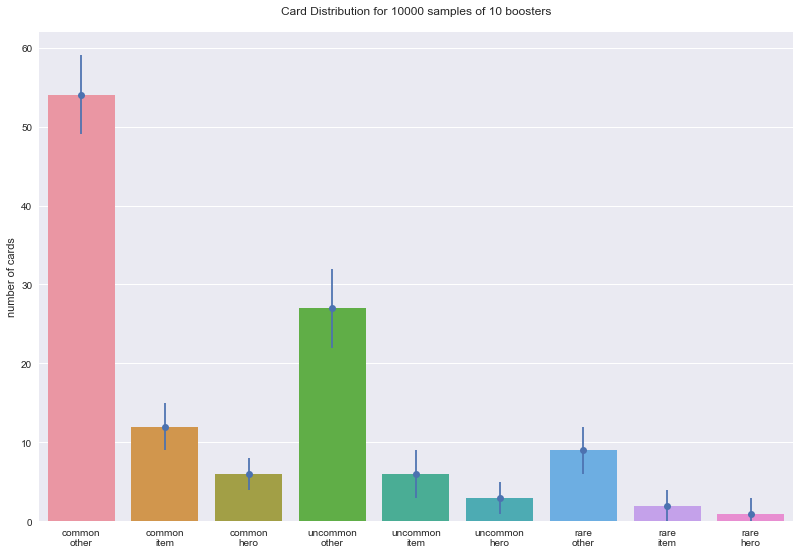

In [14]:
data = (booster_distribution
        .join(card_keys)
        .assign(combo_str=lambda df: df["rarity_value"] + "\n" + df["type_value"]))

hpdi = np.abs(data["mean"].values.reshape(-1, 1) - data[["lower", "upper"]].values).T

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
sns.barplot(ax=ax, data=data, x="combo_str", y="mean")
ax.errorbar(data["combo_str"], data["mean"], fmt="o", yerr=hpdi)

ax.set_title("Card Distribution for {} samples of 10 boosters\n".format(NUM_SAMPLES, NUM_BOOSTERS))
ax.set_ylabel("number of cards")
ax.set_xlabel("");

## Expected Prices

Using the booster distribution, I can build the expected price distribution based on the prices of each `rarity-type` on the market

In [15]:
market_prices = (market_rarity
                 .assign(rarity_value=lambda df: df["rarity"].str.lower())
                 .assign(type_value=lambda df: df["type"].str.lower())
                 .assign(type_value=lambda df: np.where(df["type_value"].isin(type_key.keys()),
                                                        df["type_value"],
                                                        "other"))
                 .merge(card_keys.reset_index(), on=["rarity_value", "type_value"])
                 .set_index("combo_key"))

market_prices.head()

,name,price,rarity,type,rarity_value,type_value,rarity_key,type_key
combo_key,,,,,,,,
5,Arcane Assault,2.11,Common,Spell,common,other,1,5
5,Arcane Censure,2.30,Common,Spell,common,other,1,5
5,Arm the Rebellion,2.23,Common,Spell,common,other,1,5
5,Avernus' Blessing,2.20,Common,Spell,common,other,1,5
5,Bellow,2.14,Common,Spell,common,other,1,5


In [16]:
market_stats = (market_prices
                .groupby("combo_key")
                [["name"]]
                .count()
                .rename(columns={"name": "price_count"})
                .assign(padding=lambda df: df["price_count"].max() - df["price_count"])
                .loc[card_keys.index])
market_stats

,price_count,padding
combo_key,,
5,48,4
7,14,38
11,20,32
10,52,0
14,14,38
22,12,40
15,52,0
21,13,39
33,12,40


In [17]:
acc = []
for idx in card_keys.index:
    prices = market_prices.loc[idx]["price"].values
    padding = market_stats.loc[idx]["padding"]
    padded = np.pad(prices, (0, padding), "constant")
    acc.append(padded)
price_matrix = np.vstack(acc)
price_matrix.shape

(9, 52)

In [18]:
price_counts = market_stats.loc[card_keys.index]["price_count"].values
samples_mu = samples/price_counts

samples_price = []
for sample_mu in samples_mu:
    sample_mu = np.tile(sample_mu, (price_matrix.shape[1], 1)).T
    sample_draw = stats.poisson.rvs(mu=sample_mu)
    sample_price = np.sum(sample_draw * price_matrix)
    samples_price.append(sample_price)
samples_price = np.array(samples_price)
samples_price.shape

(10000,)

### Probability of seeing at least my price?

In [19]:
(samples_price > my_price).sum()/len(samples_price)

0.1969

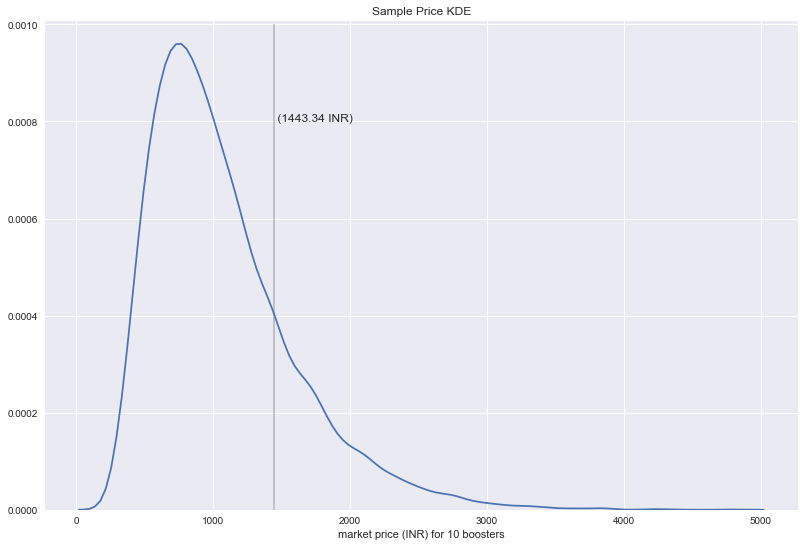

In [20]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
sns.kdeplot(samples_price)
ax.vlines(my_price, 0, 0.001, alpha=0.2)
ax.text(my_price, 0.0008, " ({} INR) ".format(my_price))
ax.set_title("Sample Price KDE")
ax.set_xlabel("market price (INR) for 10 boosters");

## Conclusion

Although the expected price for all 10 boosters is below the price I received, my price isn't that unlikely. Valve doesn't need to change the card distribution dynamically in order for me to receive my price.

In [21]:
mu = samples_price.mean()
(lb, ub) = np.percentile(samples_price, [5.5, 94.5])
break_even = (samples_price > 1499).sum()/NUM_SAMPLES * 100
pd.DataFrame([[mu, lb, ub, break_even]], 
             columns=["Mean", "5.5%", "94.5%", "break even %"],
             index=["Summary"]).round(2).T

,Summary
Mean,1069.38
5.5%,455.37
94.5%,2061.33
break even %,17.58


It's not unlikely to "break even" especially if you consider the Starter Decks which I haven't done here.